In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Run NSGA-II with adjusted parameters
population_size = 200 
num_generations = 500
num_variables = 1000
crossover_rate = 0.9
mutation_rate = 0.1

In [3]:
# Define the ZDT1 test function
def zdt1_objective(population: np.ndarray) -> np.ndarray:
    """
    Calculate the objective values for the ZDT1 test function.

    Parameters:
        population (np.ndarray): The population matrix where each row is a solution.

    Returns:
        np.ndarray: An array of objective values, where each row corresponds to a solution.
    """
    f1 = population[:, 0]
    g = 1 + 9 * np.sum(population[:, 1:], axis=1) / (population.shape[1] - 1)
    f2 = g * (1 - np.sqrt(f1 / g))
    return np.column_stack((f1, f2))

In [4]:
# Perform nondominated sorting
def nondominated_sorting(objectives: np.ndarray) -> list[list[int]]:
    """
    Perform nondominated sorting on a set of objective values.

    Parameters:
        objectives (np.ndarray): Array of objective values, where each row is a solution.

    Returns:
        list[list[int]]: A list of fronts, where each front is a list of indices of the solutions.
    """
    num_solutions = objectives.shape[0]
    domination_counts = np.zeros(num_solutions, dtype=int)
    dominated_solutions = [[] for _ in range(num_solutions)]
    fronts = [[]]

    for i in range(num_solutions):
        for j in range(num_solutions):
            if all(objectives[i] <= objectives[j]) and any(objectives[i] < objectives[j]):
                dominated_solutions[i].append(j)
            elif all(objectives[j] <= objectives[i]) and any(objectives[j] < objectives[i]):
                domination_counts[i] += 1

        if domination_counts[i] == 0:
            fronts[0].append(i)

    current_front = 0
    while fronts[current_front]:
        next_front = []
        for i in fronts[current_front]:
            for j in dominated_solutions[i]:
                domination_counts[j] -= 1
                if domination_counts[j] == 0:
                    next_front.append(j)
        fronts.append(next_front)
        current_front += 1

    return fronts[:-1]

In [5]:
# Calculate crowding distance
def calculate_crowding_distance(front: list[int], objectives: np.ndarray) -> np.ndarray:
    """
    Calculate the crowding distance for a given front of solutions.

    Parameters:
        front (list[int]): Indices of the solutions in the front.
        objectives (np.ndarray): Array of objective values, where each row is a solution.

    Returns:
        np.ndarray: An array of crowding distances for the solutions in the front.
    """
    distances = np.zeros(len(front))
    num_objectives = objectives.shape[1]

    for m in range(num_objectives):
        sorted_indices = np.argsort(objectives[front, m])
        sorted_front = [front[i] for i in sorted_indices]
        distances[sorted_indices[0]] = distances[sorted_indices[-1]] = np.inf

        for i in range(1, len(front) - 1):
            distances[sorted_indices[i]] += (
                objectives[sorted_front[i + 1], m] - objectives[sorted_front[i - 1], m]
            ) / (objectives[sorted_front[-1], m] - objectives[sorted_front[0], m])

    return distances

In [6]:
# NSGA-II main function
def nsga2(pop_size: int, num_generations: int, num_variables: int, crossover_rate: float, mutation_rate: float) -> np.ndarray:
    """
    Run the NSGA-II algorithm on the ZDT1 benchmark.

    Parameters:
        pop_size (int): The size of the population.
        num_generations (int): The number of generations to run the algorithm.
        num_variables (int): The number of decision variables for each solution.
        crossover_rate (float): Probability of crossover.
        mutation_rate (float): Probability of mutation.

    Returns:
        np.ndarray: The final Pareto front as an array of objective values.
    """
    population = np.random.rand(pop_size, num_variables)

    def mutate(solution: np.ndarray, mutation_rate: float, sigma: float = 0.2) -> np.ndarray:
        """Apply mutation to a solution with Gaussian noise."""
        for i in range(len(solution)):
            if np.random.rand() < mutation_rate:
                solution[i] += np.random.normal(0, sigma)
                solution[i] = np.clip(solution[i], 0, 1)
        return solution

    def crossover(parent1: np.ndarray, parent2: np.ndarray, crossover_rate: float) -> np.ndarray:
        """Perform simulated binary crossover (SBX)."""
        if np.random.rand() < crossover_rate:
            child1, child2 = parent1.copy(), parent2.copy()
            for i in range(len(parent1)):
                if np.random.rand() < 0.5:
                    beta = np.random.uniform(0.5, 2.0)  # Adjusted beta range
                    child1[i] = 0.5 * ((1 + beta) * parent1[i] + (1 - beta) * parent2[i])
                    child2[i] = 0.5 * ((1 - beta) * parent1[i] + (1 + beta) * parent2[i])
            return np.vstack([child1, child2])
        return np.vstack([parent1, parent2])

    for generation in range(num_generations):
        objectives = zdt1_objective(population)
        fronts = nondominated_sorting(objectives)
    
        new_population = []
        for front in fronts:
            if len(new_population) + len(front) > pop_size:
                distances = calculate_crowding_distance(front, objectives)
                sorted_indices = np.argsort(-distances)
                front = [front[i] for i in sorted_indices]
    
            new_population.extend(front[: max(0, pop_size - len(new_population))])
    
            if len(new_population) >= pop_size:
                break
    
        selected_population = np.array([population[i] for i in new_population])
        offspring = []
    
        while len(offspring) < pop_size:
            parents = selected_population[np.random.choice(len(selected_population), 2, replace=False)]
            children = crossover(parents[0], parents[1], crossover_rate)  # Dodano crossover_rate
            offspring.extend(children)
    
        offspring = np.array([mutate(child, mutation_rate, sigma=0.2) for child in offspring[:pop_size]])
        population = np.vstack((selected_population, offspring))[:pop_size]

    return zdt1_objective(population)

In [7]:
# Run NSGA-II
final_front = nsga2(population_size, num_generations, num_variables, crossover_rate, mutation_rate)

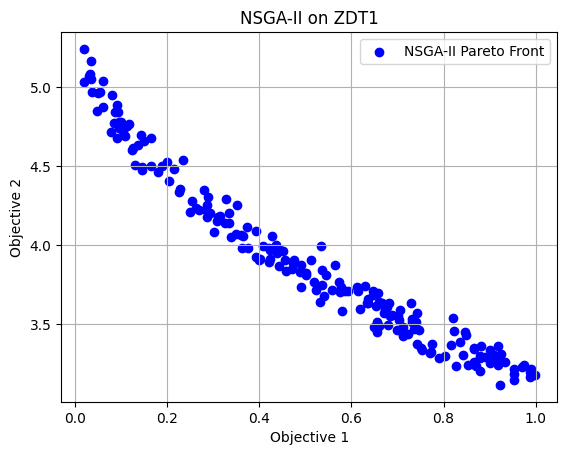

In [8]:
# Plot results
plt.scatter(final_front[:, 0], final_front[:, 1], c="blue", label="NSGA-II Pareto Front")
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.title("NSGA-II on ZDT1")
plt.legend()
plt.grid(True)
plt.show()